# 使用Keras快速构建一个简单网络模型

* 使用Keras构建一个简单神经网络来解决二分类问题

## 导入需要的包

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

import sklearn
import sklearn.datasets

import matplotlib
import matplotlib.pyplot as plt

# display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

Using TensorFlow backend.


## 生成一个数据集
`sklearn.datasets.make_moons`用于产生一个简单的样本数据集
参数：
* n_samples: 整数型，默认100，总的产生样本数量
* shuffle: 布尔型，默认`True`，是否打乱数据顺序
* noise: 浮点型，默认为`None`，加到数据里面的高斯噪声的标准差
返回值：
* X：形如`[n_samples, 2]`的样本数组
* y：形如`[n_samples]`的分类结果(0/1)数组

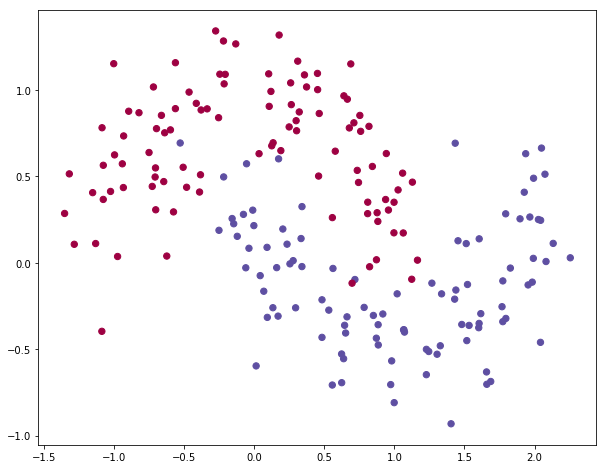

In [0]:
# generate a dataset and plot it
np.random.seed(0)
X_train, y_train = sklearn.datasets.make_moons(200, noise=0.2)
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)

In [0]:
print(X_train[0])
print(y_train[0])
print(X_train.shape)
print(y_train.shape)

[0.74346118 0.46465633]
0
(200, 2)
(200,)


In [0]:
def plot_decision_boundary(pred_func):
    # set min and max values and give it some padding
    x_min, x_max = X_train[:,0].min() - .5, X_train[:,0].max() + .5
    y_min, y_max = X_train[:,1].min() - .5, X_train[:,1].max() + .5
    h = 0.01
    # generate a grid of points with distance h between them
    x_l, y_l = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # predict the function value for the whole grid
    Z = pred_func(np.c_[x_l.ravel(), y_l.ravel()])
    Z = Z.reshape(x_l.shape)
    # plot the contour and training examples
    filled = plt.contourf(x_l, y_l, Z, 1, cmap=plt.cm.Spectral)
    line = plt.contour(x_l, y_l, Z, 0, colors='black', linewidths=.5)
    plt.colorbar(filled, ticks=[0,1])
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.Spectral)

对于上面的函数稍微解释一下（可以直接跳到后面构建网络模型，这只是一个辅助函数）：
`meshgrid()`函数用来生成一个网络数据，例如：
```python
>>>x, y = np.meshgrid([1,2],[3,4])
>>>x
array([[1, 2],
       [1, 2]])
>>>y
array([[3, 3],
       [4, 4]])
```
对应四个点坐标，分别是`(1,3)、(2,3)、(1,4)、(2,4)`
***
`np.c_[]`用来按列合并(同样也有`np.r_[]`按行合并)，`ravel()`和`flatten()`一样用于返回矩阵变换成一维的向量，不过`ravel`返回的是视图，`flatten`返回的是副本，类似C++的传引用和传值：
```python
>>>a = np.array([1,2])
>>>b = np.array([3,4])
>>>c = np.c_[a.ravel(), b.ravel()]
>>>c
array([[1, 3],
       [2, 4]])
```
***
`contourf()`和`contour()`是用来画等高线图的，等高线是三维图像在二维中的一种投影，其中`Z`是关于`x_l`,`y_l`的函数，将`Z`视为三维中的高度，由`x_l`和`y_l`决定。
```python
>>>filled = plt.contourf(x_l, y_l, Z, 1, cmap=plt.cm.Spectral)
>>>plt.colorbar(filled, ticks=[0,1])
```
这里`contourf`填充轮廓，按照`Z`(高度)值填充颜色，参数`1`表示颜色细分数量，这里是2种颜色(二分类问题)。camp参考[这里](https://matplotlib.org/examples/color/colormaps_reference.html)。
`colorbar`添加colorbar，默认在右边竖直。
```python
>>>plt.contour(x_l, y_l, Z, 0, colors='black', linewidth=.5)
```
`contour`填充轮廓线，按照`Z`(高度)值，参数`0`控制等高线数量(这里的高度就0和1)

演示一下：

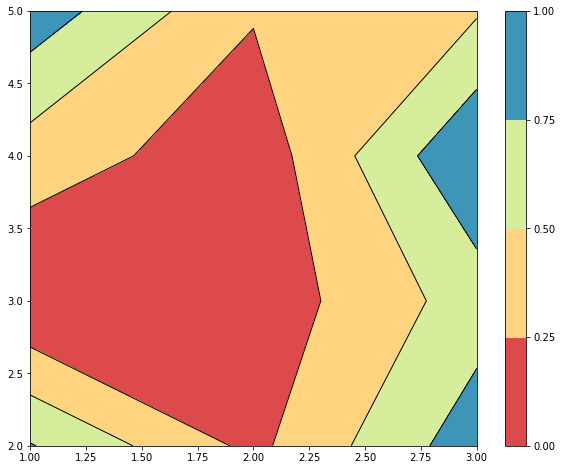

In [0]:
x = np.array([1,2,3])
y = np.array([2,3,4,5])
x_l, y_l = np.meshgrid(x, y)
Z = np.random.random((4,3)) # 这里就随机生成了Z(高度)值，形状要和网格形状一样
filled = plt.contourf(x_l, y_l, Z, 3, cmap=plt.cm.Spectral)
plt.colorbar(filled, ticks=np.arange(0,1.1,0.25))
line = plt.contour(x_l, y_l, Z, 3, colors='black', linewidths=1)

可以看出，`plot_decision_boundary`函数，首先将网络里所有的坐标，按照`pred_func`预测出来的值作为`Z`(高度)值，这样网络里的所有点都被预测分类了，这样画出等高线也就很明显看出训练出来的模型对于数据的预测效果。最后，将训练集的的数据再画上去：
```python
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)

```

## 构建网络模型并训练

### 定义模型
* `Sequential`是Keras的顺序模型，可以将网络层实例列表传递给`Sequential`的构造器来构建一个`Sequential`模型，[详见](https://keras.io/zh/getting-started/sequential-model-guide/)

* `Dense`用于构建一个全连接的网络层，[详见](https://keras.io/zh/layers/core/#dense)

In [0]:
model = Sequential([
    Dense(32, input_dim=2, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])

Instructions for updating:
Colocations handled automatically by placer.


### 编译模型
在模型训练前，需要配置学习过程，通过`compile`函数完成。
参数：
* optimizer，优化器，传实例或者字符串都行，如‘rmsprop’。[详见](https://keras.io/zh/optimizers/)
* loss，损失函数。[详见](https://keras.io/zh/losses/)
* metrics，评估标准。[详见](https://keras.io/zh/metrics/)

In [0]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 训练模型
训练模型使用`fit`函数，[详见](https://keras.io/zh/models/sequential/#fit)

返回一个`History`对象，其属性`history`包含训练集损失和评估值。如果指定了验证集，也包括验证集的损失和评估值记录。

In [0]:
h = model.fit(X_train, y_train, epochs=1300, verbose=0)

Instructions for updating:
Use tf.cast instead.


plot the loss and accuracy.

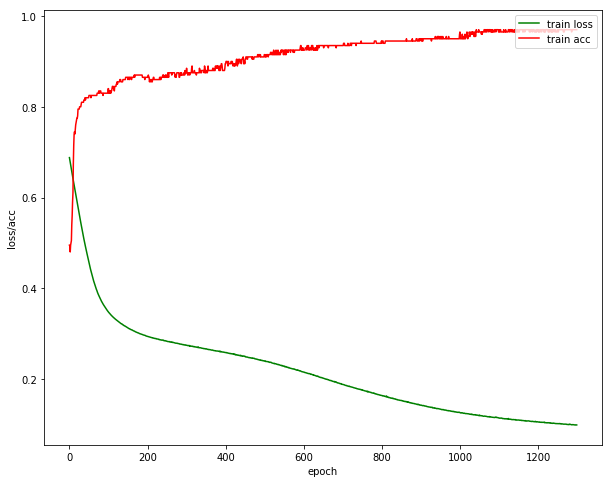

In [0]:
loss = h.history['loss']
acc = h.history['acc']
plt.figure()
plt.plot(range(len(loss)), loss[:], 'g', label='train loss')
plt.plot(range(len(acc)), acc[:], 'r', label='train acc')
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.legend(loc='upper right')
plt.show()

## 训练效果

查看网络模型在训练集上的训练效果

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


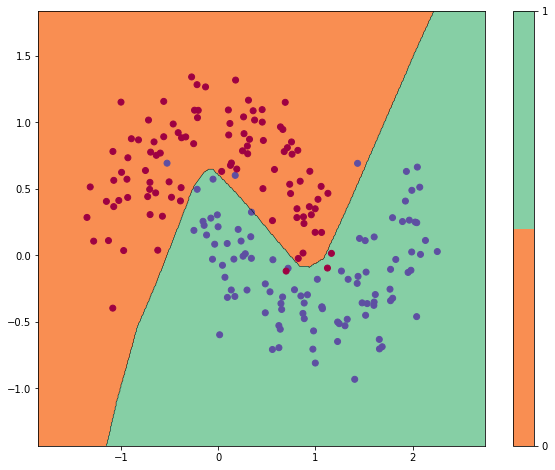

In [0]:
plot_decision_boundary(lambda x: model.predict(x) >= 0.5)